# Flowers Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

## Prepare the dataset

In [2]:
data_folder = '/home/JulioCesar/tutorials/data/lfw'
lfw_names = os.listdir(data_folder)
images_list = []
for person in lfw_names:
    for file_ in os.listdir(os.path.join(data_folder, person)):
        if file_.endswith('jpg'):
            images_list.append(os.path.join(data_folder, person, file_))
print('Found {} images'.format(len(images_list)))

Found 13233 images


In [3]:
images_list[:10]

['/home/JulioCesar/tutorials/data/lfw/Maria_Wetterstrand/Maria_Wetterstrand_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Julie_Taymor/Julie_Taymor_0002.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Julie_Taymor/Julie_Taymor_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Eva_Mendes/Eva_Mendes_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Oliver_Neuville/Oliver_Neuville_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Nicole/Nicole_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Donatella_Versace/Donatella_Versace_0001.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Donatella_Versace/Donatella_Versace_0002.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Donatella_Versace/Donatella_Versace_0003.jpg',
 '/home/JulioCesar/tutorials/data/lfw/Ilan_Goldfajn/Ilan_Goldfajn_0001.jpg']

In [4]:
train_images, test_images = train_test_split(images_list, test_size=0.2)
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 10586
Test images: 2647


In [5]:
def map_image(image_path):
    rgb = tf.io.read_file(image_path)
    rgb = tf.image.decode_jpeg(rgb, channels=3)
    rgb = tf.image.resize(rgb, (224, 224))
    gray = tf.image.rgb_to_grayscale(rgb)
    rgb = tf.cast(rgb, dtype=tf.float32)
    gray = tf.cast(gray, dtype=tf.float32)
    rgb = rgb / 255.0
    gray = gray / 255.0
    return gray, rgb

In [102]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [103]:
# def encoder(inputs, layer_filters, kernel_size, latent_dim):
#     x = inputs
#     for filters in layer_filters:
#         x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     shape = tf.keras.backend.int_shape(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(latent_dim)(x)
#     return x, shape

In [104]:
def encoder(inputs, layer_filters, kernel_size, latent_dim):
    x = inputs
    for filters in layer_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', name='output_encoder')(x)
    encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    return x, shape, encoder_visualization

In [105]:
# def decoder(inputs, shape, latent_dim, channels):
#     x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(inputs)
#     x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
    
#     for filters in layer_filters[::-1]:
#         x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
#     return x

In [106]:
def decoder(inputs, shape, latent_dim, channels):
    x = inputs
    for filters in layer_filters[::-1]:
        x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
    return x

In [122]:
def convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, channels):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder_output, shape, encoder_visualization = encoder(inputs, layer_filters, kernel_size, latent_dim)
    decoder_output = decoder(encoder_output, shape, latent_dim, channels)
    
    encoder_model_viz = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    return autoencoder_model, encoder_model_viz

In [123]:
input_shape = (224, 224, 1)
kernel_size = 3
latent_dim = 256
output_channels = 3
layer_filters = [32, 64, 128]

autoencoder_model, encoder_viz = convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, output_channels)
autoencoder_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 128)       512

In [125]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [126]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                validation_data=test_dataset, validation_steps=valid_steps, 
                                epochs=3)

Epoch 1/3
330/330 [==============================] - 105s 318ms/step - loss: 0.0103 - val_loss: 0.0362
Epoch 2/3
330/330 [==============================] - 106s 321ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 3/3
330/330 [==============================] - 106s 320ms/step - loss: 0.0066 - val_loss: 0.0072


## Display sample

In [162]:
test_data = next(iter(test_dataset))
idx = 23
gray_img = test_data[0][idx]
color_img = test_data[1][idx]

In [163]:
predicted = autoencoder_model.predict(gray_img[tf.newaxis, ...])

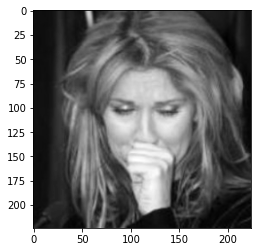

In [164]:
plt.imshow(np.squeeze(gray_img), cmap='gray')

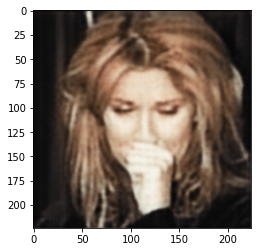

In [165]:
plt.imshow(np.squeeze(predicted))

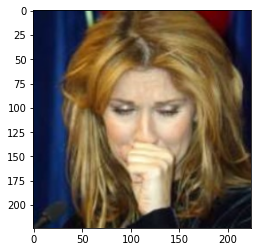

In [166]:
plt.imshow(np.squeeze(color_img))

## Get encoder and decoder models

In [167]:
encoder_model = tf.keras.Model(inputs=autoencoder_model.input, 
                               outputs=autoencoder_model.get_layer('output_encoder').output)
encoder_model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 128)       512

In [168]:
encoder_viz.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 128)       512

In [169]:
encoder_model.output.shape

TensorShape([None, 28, 28, 256])

## Show encoded

In [170]:
encoded = encoder_model.predict(gray_img[tf.newaxis, ...])[0]
encoded_viz = encoder_viz.predict(gray_img[tf.newaxis, ...])[0]

In [171]:
print(encoded.shape)
print(encoded_viz.shape)

(28, 28, 256)
(28, 28, 1)


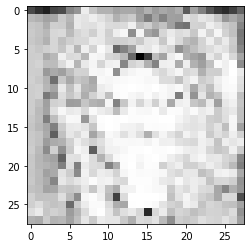

In [172]:
plt.imshow(np.squeeze(encoded_viz), cmap='gray')